# Code to train LightGBM model
This notebook was made on Google Colab ([link to notebook](https://colab.research.google.com/drive/1VtCe6znPTggCk5Bp_CJ1Hv9eRtgBdtT0?usp=sharing)). If you are running on your local machine remove the cells related to data retrieval and RDKit installation, and change the paths to the files as needed.


#Software installation and data retrieval, etc.

In [2]:
%%capture
# Install RDKit
# takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

In [3]:
%%capture
! rm -f lightgbm_density_train_data.csv lightgbm_barrier_train_data.csv
! wget https://sid.erda.dk/share_redirect/EwaEr2JMrb/all_230_billion/ml_data/lightgbm_density_train_data.csv
! wget https://sid.erda.dk/share_redirect/EwaEr2JMrb/all_230_billion/ml_data/lightgbm_barrier_train_data.csv

In [4]:
import sys
import re
from collections import OrderedDict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# RDKit
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

# ML
from sklearn.model_selection import train_test_split
import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 
plt.rcParams['axes.labelsize'] = 16

# Helper Functions
Functions to make RDKit object and the find number of substituents from gene names.

In [6]:
ligands = ['H', 'F', 'Cl', 'Br', 'C(F)(F)(F)', 'C#N',
           '[N+](=O)([O-])', 'C(=O)[H]', 'C(=O)O',
           'C(=O)C', 'C(=O)N', 'C#C', 'S(=O)(=O)(C)',
           'C=N', 'O', 'OC', 'N', 'N(C)(C)', 'C',
           'N(C(=O)(C))', 'SC', 'C3=CC=C(F)C=C3',
           'C3=CC=C(Cl)C=C3', 'C3=CC=C(Br)C=C3',
           'C3=CC=C(C(F)(F)(F))C=C3',
           'C3=CC=C(C#N)C=C3', 'C3=CC=C([N+](=O)([O-]))C=C3',
           'C3=CC=C(C(=O)[H])C=C3', 'C3=CC=C(C(=O)O)C=C3',
           'C3=CC=C(C(=O)C)C=C3', 'C3=CC=C(C(=O)N)C=C3',
           'C3=CC=C(C#C)C=C3', 'C3=CC=C(S(=O)(=O)(C))C=C3',
           'C3=CC=C(C=N)C=C3', 'C3=CC=C(O)C=C3',
           'C3=CC=C(OC)C=C3', 'C3=CC=C(N)C=C3',
           'C3=CC=C(N(C)(C))C=C3', 'C3=CC=C(C)C=C3',
           'C3=CC=C(N(C(=O)(C)))C=C3', 'C3=CC=C(SC)C=C3',
           'C3=CC=CC=C3']


ligand_num2smiles = OrderedDict(zip(list(range(len(ligands))),ligands))

def get_mol(gene):
    global ligands

    gene = gene.split('-')
    
    core = 'N#CC1(C#N)C(1)=C(2)C2=C(3)C(4)=C(5)C(6)=C(7)C21'
    
    gene_smiles = core
    for i, ligand_idx in enumerate(gene):
        substr = ligands[int(ligand_idx)]
        if substr == 'H':
            continue
        gene_smiles = gene_smiles.replace('('+str(i+1)+')', f'({substr})')
    
    mol = Chem.MolFromSmiles(re.sub('\([0-9]\)', '', gene_smiles))

    return mol

def num_subs(gene):
    gene = [int(x) for x in gene.split('-')]
    return 7 - gene.count(0)


def get_smiles(rdkit_mol):
    return Chem.MolToSmiles(Chem.RemoveHs(rdkit_mol))

# Prepare Data

In [7]:
df_density = pd.read_csv('lightgbm_density_train_data.csv', sep=',')
df_density['num_subs'] = df_density['gene'].apply(num_subs)

In [8]:
df_barrier_scan = pd.read_csv('lightgbm_barrier_train_data.csv')
df_barrier_scan['num_subs'] = df_barrier_scan['gene'].apply(num_subs)

# Train LightGBM Model

## Function for One-Hot Encoding


In [9]:
def one_hot(gene):
    """Creates one-hot representation"""
    one_hot = np.zeros((7,41), dtype=np.float32)
    for i, base in enumerate([int(x) for x in gene.split('-')]):
        if base == 0:
            continue
        one_hot[i,base - 1] = 1.
    return one_hot

def training_data_one_hot(df, prop='density'):
    """ Create Matrices and Vectors with representation and targets repectively """
    Xs = np.empty((df.shape[0], 287))
    ys = np.empty(df.shape[0])
    
    for i, row in enumerate(df.itertuples()):
        Xs[i] = one_hot(row.gene).flatten()
        ys[i] = getattr(row, prop)
    
    return Xs, ys

### Density Data

In [10]:
df_train_density, df_test_density = train_test_split(df_density, test_size=0.25, random_state=42)
df_test_density, df_val_density = train_test_split(df_test_density, test_size=0.50, random_state=42)

print(f"train size: {df_train_density.shape[0]}, validation size: {df_val_density.shape[0]}, test size: {df_test_density.shape[0]}")

train size: 39057, validation size: 6510, test size: 6509


In [11]:
train_data_density, train_label_density = training_data_one_hot(df_train_density, prop='xtb_density')
lgb_train_density = lgb.Dataset(train_data_density, label=train_label_density)

val_data_density, val_label_density = training_data_one_hot(df_val_density, prop='xtb_density')
lgb_val_density = lgb.Dataset(val_data_density, label=val_label_density)

test_data_density, test_label_density = training_data_one_hot(df_test_density, prop='xtb_density')
lgb_test_density = lgb.Dataset(test_data_density, label=test_label_density)

### Barrier Data

In [12]:
df_train_barrier, df_test_barrier = train_test_split(df_barrier_scan, test_size=0.17, random_state=42)
df_test_barrier, df_val_barrier = train_test_split(df_test_barrier, test_size=0.40, random_state=42)

print(f"train size: {df_train_barrier.shape[0]}, validation size: {df_val_barrier.shape[0]}, test size: {df_test_barrier.shape[0]}")

train size: 29858, validation size: 2447, test size: 3669


In [13]:
train_data_barrier, train_label_barrier = training_data_one_hot(df_train_barrier, prop='pm3_barrier_scan')
lgb_train_barrier = lgb.Dataset(train_data_barrier, label=train_label_barrier)

val_data_barrier, val_label_barrier = training_data_one_hot(df_val_barrier, prop='pm3_barrier_scan')
lgb_val_barrier = lgb.Dataset(val_data_barrier, label=val_label_barrier)

test_data_barrier, test_label_barrier = training_data_one_hot(df_test_barrier, prop='pm3_barrier_scan')
lgb_test_barrier = lgb.Dataset(test_data_barrier, label=test_label_barrier)

## Train Models

In [14]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'rmse'],
    'num_leaves': 80,
    'max_depth': 7, 
    'min_data_in_leaf': 50,
    'max_bin': 100,
    'learning_rate': 0.10,
    'seed': 42}

num_round = 10000
model_lgb_density = lgb.train(params, lgb_train_density, num_round, valid_sets=[lgb_val_density],
                        early_stopping_rounds=200, verbose_eval=1000)

Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 0.0388473	valid_0's l2: 0.00150912
[2000]	valid_0's rmse: 0.0361719	valid_0's l2: 0.00130841
[3000]	valid_0's rmse: 0.0353111	valid_0's l2: 0.00124688
[4000]	valid_0's rmse: 0.0349998	valid_0's l2: 0.00122498
[5000]	valid_0's rmse: 0.03493	valid_0's l2: 0.00122011
Early stopping, best iteration is:
[5345]	valid_0's rmse: 0.0349065	valid_0's l2: 0.00121847


In [15]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'rmse'],
    'num_leaves': 8,
    'max_depth': 3, 
    'min_data_in_leaf': 80,
    'max_bin': 100,
    'learning_rate': .25,
    'seed': 42}

max_num_trees = 10000

model_lgb_barrier = lgb.train(params, lgb_train_barrier, max_num_trees, valid_sets=[lgb_val_barrier],
                            early_stopping_rounds=100, verbose_eval=500)

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 23.8555	valid_0's l2: 569.086
[1000]	valid_0's rmse: 22.738	valid_0's l2: 517.016
[1500]	valid_0's rmse: 22.0043	valid_0's l2: 484.19
[2000]	valid_0's rmse: 21.5609	valid_0's l2: 464.871
[2500]	valid_0's rmse: 21.3477	valid_0's l2: 455.725
[3000]	valid_0's rmse: 21.1483	valid_0's l2: 447.249
[3500]	valid_0's rmse: 21.0171	valid_0's l2: 441.72
[4000]	valid_0's rmse: 20.916	valid_0's l2: 437.481
[4500]	valid_0's rmse: 20.8465	valid_0's l2: 434.576
Early stopping, best iteration is:
[4892]	valid_0's rmse: 20.8097	valid_0's l2: 433.045


# Make Figure 5

In [16]:
ypred_test_density = model_lgb_density.predict(test_data_density, num_iteration=model_lgb_density.best_iteration)
ypred_test_barrier = model_lgb_barrier.predict(test_data_barrier, num_iteration=model_lgb_barrier.best_iteration)

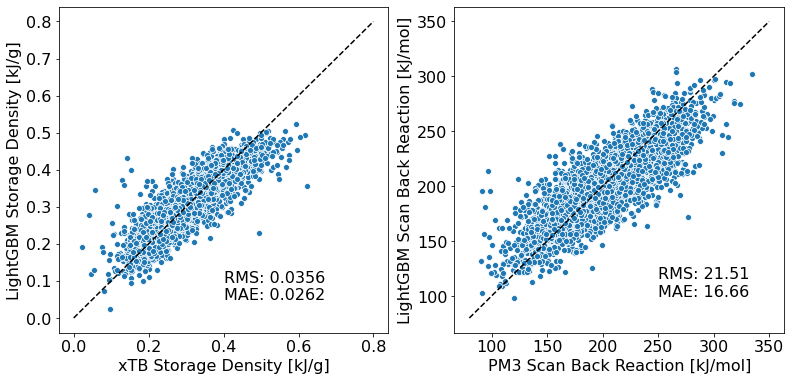

In [17]:
fig, ax = plt.subplots(figsize=(13,6), ncols=2)

# Plot Density
sns.scatterplot(test_label_density, ypred_test_density, ax=ax[0])
ax[0].plot([0.0, 0.80], [0.0, 0.80], c='k', linestyle='--')

error_density = ypred_test_density - test_label_density
mae = abs(error_density).mean()
rms = (error_density).std()

ax[0].set(xlabel='xTB Storage Density [kJ/g]', ylabel='LightGBM Storage Density [kJ/g]')
s_density = f'RMS: {rms:.4f} \nMAE: {mae:.4f}'
ax[0].text(0.40,0.05, s_density, {'fontsize': 16})

# Plot Barrier
sns.scatterplot(test_label_barrier, ypred_test_barrier, ax=ax[1])
ax[1].plot([80, 350], [80, 350], c='k', linestyle='--')

error_barrier = ypred_test_barrier - test_label_barrier
mae = abs(error_barrier).mean()
rms = (error_barrier).std()

ax[1].set(xlabel='PM3 Scan Back Reaction [kJ/mol]', ylabel='LightGBM Scan Back Reaction [kJ/mol]')
s_barrier = f'RMS: {rms:.2f} \nMAE: {mae:.2f}'
ax[1].text(250,100, s_barrier, {'fontsize': 16});